In [2]:
!pip install --upgrade google-colab

from google.colab import drive
drive.mount('/content/drive')

ERROR: Could not find a version that satisfies the requirement google-colab (from versions: none)
ERROR: No matching distribution found for google-colab

[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


ModuleNotFoundError: No module named 'google'

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
%matplotlib inline
import warnings
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator


warnings.filterwarnings('ignore')


pd.pandas.set_option('display.max_columns',None)

In [3]:
dataset = pd.read_csv('/content/drive/MyDrive/Balanced/balanced_resized_dataset_64x64.csv')

In [4]:
IMG_H=64
IMG_W=64

In [5]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(dataset.drop(columns=['label']), dataset['label'], test_size=0.2, random_state=42)

In [6]:
import gc
del dataset
gc.collect()

4

In [7]:
classes={0:('actinic keratoses and intraepithelial carcinomae(Cancer)'),
         1:('basal cell carcinoma(Cancer)'),
         2:('benign keratosis-like lesions(Non-Cancerous)'),
         3:('dermatofibroma(Non-Cancerous)'),
         4:('melanocytic nevi(Non-Cancerous)'),
         5:('pyogenic granulomas and hemorrhage(Can lead to cancer)'),
         6:('melanoma(Cancer)')}

In [8]:
for k in range(7):
  print("Number of ", classes[k],"images: ", len([i for i in y_train if i==k]))

Number of  actinic keratoses and intraepithelial carcinomae(Cancer) images:  2801
Number of  basal cell carcinoma(Cancer) images:  2812
Number of  benign keratosis-like lesions(Non-Cancerous) images:  2819
Number of  dermatofibroma(Non-Cancerous) images:  2828
Number of  melanocytic nevi(Non-Cancerous) images:  2774
Number of  pyogenic granulomas and hemorrhage(Can lead to cancer) images:  2758
Number of  melanoma(Cancer) images:  2808


In [9]:
x_train = x_train.values.reshape(-1, IMG_H,IMG_W, 3)
x_test = x_test.values.reshape(-1, IMG_H,IMG_W, 3)

x_train = x_train / 255.0
x_test = x_test / 255.0

y_train = to_categorical(y_train, num_classes=7)
y_test = to_categorical(y_test, num_classes=7)

### Training

In [10]:
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.layers import Flatten, Dense, Input, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint


# Base model
base_model = EfficientNetB4(weights='imagenet', include_top=False, input_shape=(IMG_H, IMG_W, 3))

# Set layers to be trainable
for layer in base_model.layers:
    layer.trainable = True

# Custom head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, kernel_regularizer='l2', activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(7, activation='softmax')(x)

# Final model
model = Model(inputs=base_model.input, outputs=x)

model.summary()



# Compile the model
optimizer = Adam(0.0001)
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

# Callbacks
lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2, mode='max', min_lr=0.00001, verbose=1)
early_stop = EarlyStopping(monitor="val_loss", patience=4, verbose=1)
model_chkpt = ModelCheckpoint('artifacts/EfficientNetB4/best_EfficientNetB4_model_new.keras', save_best_only=True, monitor='val_accuracy', verbose=1)

# Callback list
callback_list = [model_chkpt, lr_reduce, early_stop]


71686520/71686520 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 64, 64, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 64, 64, 3)      │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 64, 64, 3)      │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 64, 64, 3)      │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 65, 65, 3)      │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 32, 32, 48)     │          1,296 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 32, 32, 48)     │            192 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 32, 32, 48)     │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 32, 32, 48)     │            432 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 32, 32, 48)     │            192 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 32, 32, 48)     │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 48)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 48)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 12)       │            588 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand    

 Total params: 18,134,630 (69.18 MB)

 Trainable params: 18,009,423 (68.70 MB)

 Non-trainable params: 125,207 (489.09 KB)

In [ ]:
history = model.fit(x_train,
                      y_train,
                      validation_split=0.2,
                      batch_size=256,
                      epochs=20,
                      shuffle=True,
                      callbacks=callback_list)

Epoch 1/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2081 - loss: 6.3486   
Epoch 1: val_accuracy improved from -inf to 0.13954, saving model to artifacts/EfficientNetB4/best_EfficientNetB4_model_new.keras
62/62 ━━━━━━━━━━━━━━━━━━━━ 314s 2s/step - accuracy: 0.2092 - loss: 6.3441 - val_accuracy: 0.1395 - val_loss: 5.9523 - learning_rate: 1.0000e-04
Epoch 2/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - accuracy: 0.4431 - loss: 5.2845
Epoch 2: val_accuracy did not improve from 0.13954
62/62 ━━━━━━━━━━━━━━━━━━━━ 64s 275ms/step - accuracy: 0.4437 - loss: 5.2811 - val_accuracy: 0.1395 - val_loss: 5.3952 - learning_rate: 1.0000e-04
Epoch 3/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - accuracy: 0.5712 - loss: 4.4344
Epoch 3: val_accuracy improved from 0.13954 to 0.14107, saving model to artifacts/EfficientNetB4/best_EfficientNetB4_model_new.keras
62/62 ━━━━━━━━━━━━━━━━━━━━ 23s 316ms/step - accuracy: 0.5714 - loss: 4.4320 - val_accuracy: 0.1411 - val_loss: 4.9857 - learning_rate: 1.0

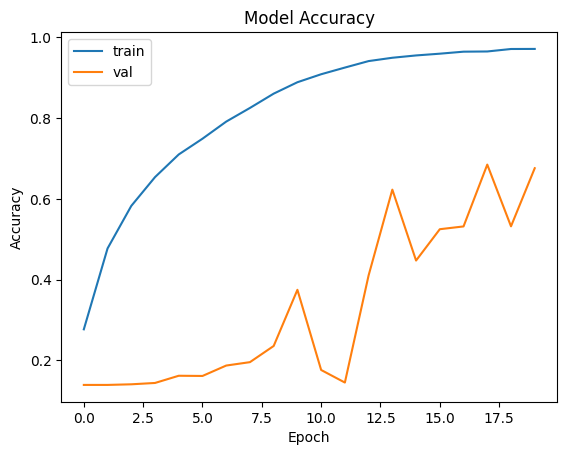

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc = 'upper left')
plt.show()

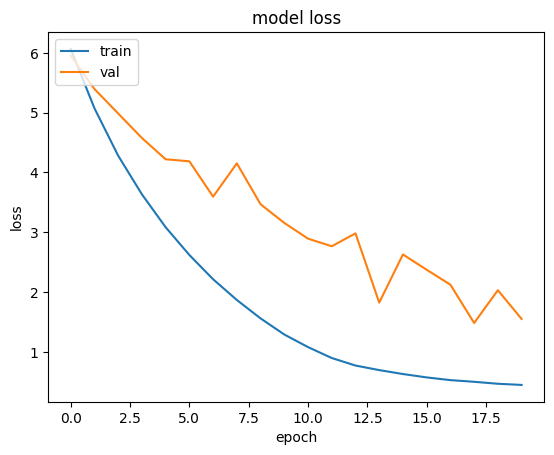

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
history = model.fit(x_train,
                      y_train,
                      validation_split=0.2,
                      batch_size=256,
                      epochs=20,
                      shuffle=True,
                      callbacks=callback_list)

Epoch 1/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - accuracy: 0.9744 - loss: 0.4265
Epoch 1: val_accuracy improved from -inf to 0.75128, saving model to artifacts/EfficientNetB4/T2/best_EfficientNetB4_model_new.keras
62/62 ━━━━━━━━━━━━━━━━━━━━ 25s 404ms/step - accuracy: 0.9744 - loss: 0.4265 - val_accuracy: 0.7513 - val_loss: 1.2423 - learning_rate: 1.2500e-05
Epoch 2/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - accuracy: 0.9747 - loss: 0.4176
Epoch 2: val_accuracy did not improve from 0.75128
62/62 ━━━━━━━━━━━━━━━━━━━━ 34s 287ms/step - accuracy: 0.9747 - loss: 0.4176 - val_accuracy: 0.7110 - val_loss: 1.4225 - learning_rate: 1.2500e-05
Epoch 3/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - accuracy: 0.9734 - loss: 0.4116
Epoch 3: val_accuracy improved from 0.75128 to 0.78750, saving model to artifacts/EfficientNetB4/T2/best_EfficientNetB4_model_new.keras
62/62 ━━━━━━━━━━━━━━━━━━━━ 25s 357ms/step - accuracy: 0.9734 - loss: 0.4115 - val_accuracy: 0.7875 - val_loss: 1.0801 - learning_r

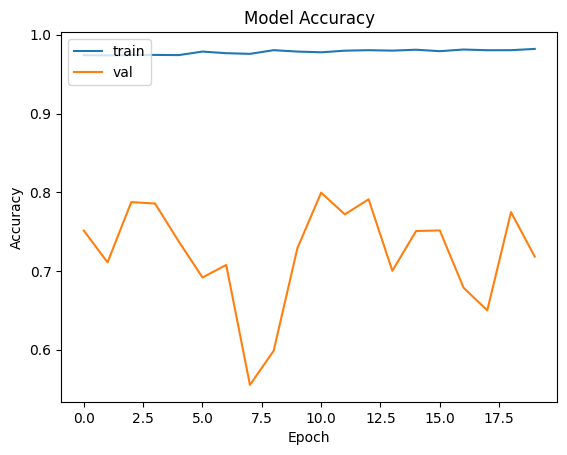

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc = 'upper left')
plt.show()

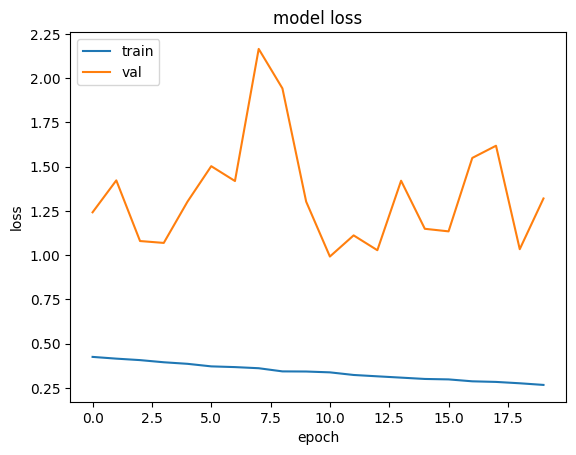

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
save_path = '/content/drive/MyDrive/artifacts/EfficientNetB4/best_EfficientNetB4_model_new.keras'
model.save(save_path)

In [ ]:
loss, acc = model.evaluate(x_test, y_test, verbose=2)
print(f"Test accuracy: {acc*100:.2f}%")

154/154 - 23s - 152ms/step - accuracy: 0.7290 - loss: 1.3185
Test accuracy: 72.90%


In [11]:
from tensorflow import keras
from sklearn.metrics import classification_report
import numpy as np

# Loading the best model
best_model = keras.models.load_model('/content/drive/MyDrive/artifacts/EfficientNetB4/best_EfficientNetB4_model_new.keras')

# Evaluate model accuracy
loss, acc = best_model.evaluate(x_test, y_test, verbose=2)
print(f"Test accuracy of the best model: {acc*100:.2f}%")

# Get model predictions
y_pred_prob = best_model.predict(x_test)  # Get probability outputs

# Convert probabilities to class labels (for multi-class classification)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)  # If y_test is one-hot encoded

# Print classification report
print(classification_report(y_true, y_pred))

154/154 - 781s - 5s/step - accuracy: 0.7292 - loss: 1.3185
Test accuracy of the best model: 72.92%
154/154 ━━━━━━━━━━━━━━━━━━━━ 788s 5s/step
              precision    recall  f1-score   support

           0       0.77      0.49      0.60       699
           1       0.63      0.78      0.70       688
           2       0.48      0.74      0.58       681
           3       0.89      0.88      0.88       672
           4       0.83      0.76      0.79       726
           5       0.96      0.97      0.97       742
           6       0.68      0.47      0.56       692

    accuracy                           0.73      4900
   macro avg       0.75      0.73      0.73      4900
weighted avg       0.75      0.73      0.73      4900



In [12]:
# Generate classification report as a dictionary
report = classification_report(y_true, y_pred, output_dict=True)

# Extract single precision & recall
precision = report["weighted avg"]["precision"]
recall = report["weighted avg"]["recall"]

print(f"Overall Precision: {precision:.2f}")
print(f"Overall Recall: {recall:.2f}")


Overall Precision: 0.75
Overall Recall: 0.73


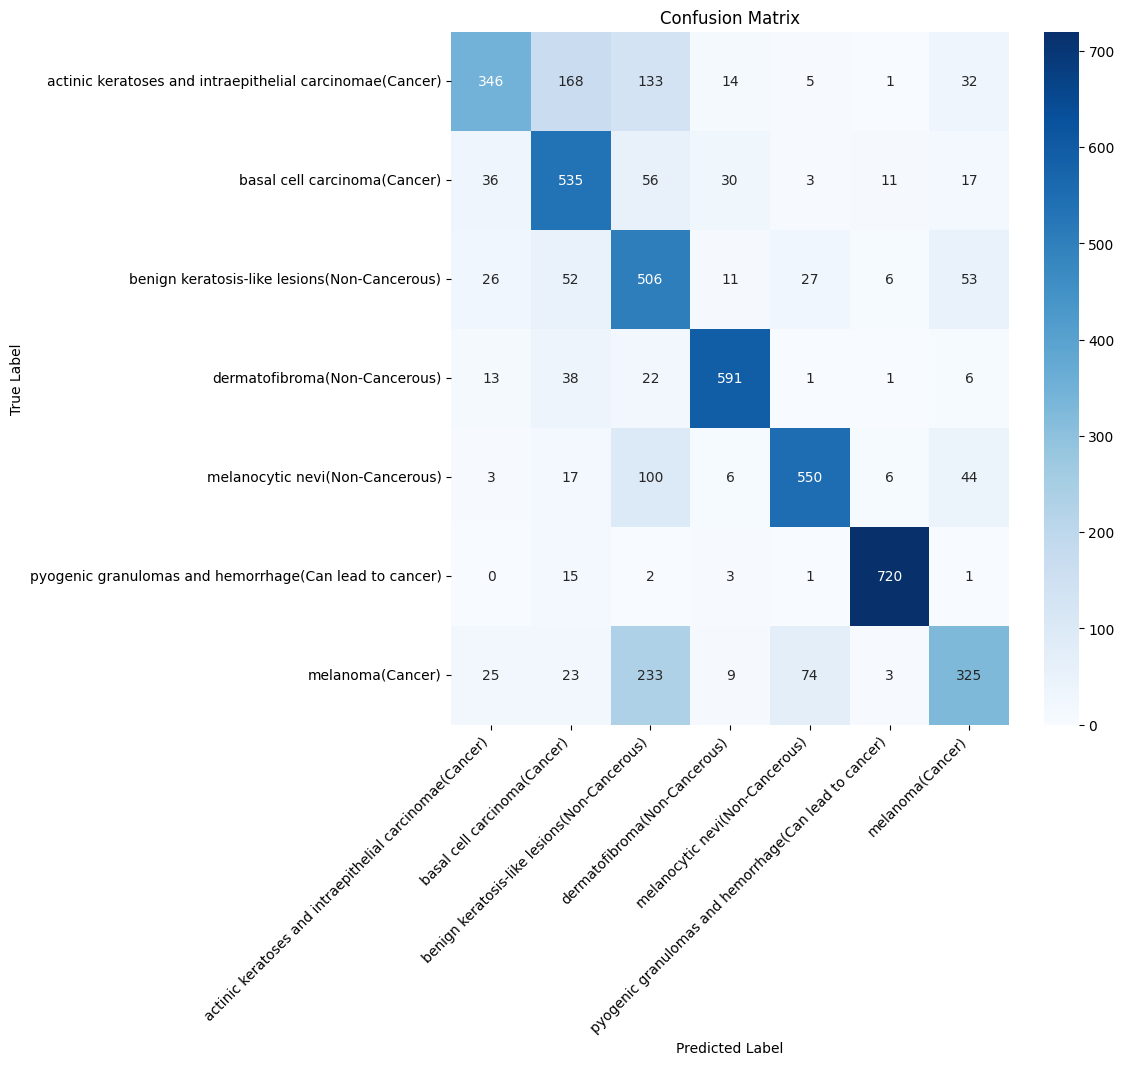

Classification Report:
                                                           precision    recall  f1-score   support

actinic keratoses and intraepithelial carcinomae(Cancer)       0.77      0.49      0.60       699
                            basal cell carcinoma(Cancer)       0.63      0.78      0.70       688
            benign keratosis-like lesions(Non-Cancerous)       0.48      0.74      0.58       681
                           dermatofibroma(Non-Cancerous)       0.89      0.88      0.88       672
                         melanocytic nevi(Non-Cancerous)       0.83      0.76      0.79       726
  pyogenic granulomas and hemorrhage(Can lead to cancer)       0.96      0.97      0.97       742
                                        melanoma(Cancer)       0.68      0.47      0.56       692

                                                accuracy                           0.73      4900
                                               macro avg       0.75      0.73      0.73     

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


class_names = [classes[i] for i in range(len(classes))]  # Converting dict to ordered list

# Generating the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(9, 9))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for better readability
plt.yticks(rotation=0)
plt.show()

print("Classification Report:\n", classification_report(y_true, y_pred, target_names=class_names))
